In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge

import scipy
from utils_stat_process import post_process
from utils_stat_feature import extract_features
from utils_stat_vis import plot_hist_w_two_list, plot_raw_filter, plot_local_peaks

In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/Paper_MIA/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/Paper_MIA/data/ann_geojsons"
DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/Paper_MIA/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/Paper_MIA/results/figures"

CUREGN = [
    "2_6063_A_0045151",
    "2_4827_A_0045173",
    "2_6088_A_0037223",
    "2_6094_A_0039851",
    "2_6097_A_0045196",
    "2_4839_A_0039862",
    "2_4841_A_0045207",
    "2_4848_A_0039884",
    "2_6128_A_0037277",
    "2_6130_A_0037288"
]

# Data Prep

### Load Labels Assigned by Jeff

In [3]:
PATH_LABEL_JEFF = "/Users/jinzhou/Desktop/Paper_MIA/data/labels_jeff.csv"
df_label_jeff = pd.read_csv(PATH_LABEL_JEFF).set_index("Artery_ID")

### Load and Clean Thickness Measurements

In [4]:
PATH_STAT_MANUAL = os.path.join(DIR_SAVE_RESULTS, "thickness.json")
PATH_STAT_DL = os.path.join(DIR_SAVE_RESULTS, "thickness_dl.json")

In [5]:
# read thickness analysis
def read_df_from_json(path_json):
    df = pd.read_json(path_json, orient="records", lines=True)
    return df

def clean(df_thick):
    df_thick.loc[:, 'Artery_ID'] = df_thick.loc[:, 'Artery_ID'].str.split('_').str[0]        
    # Set and WSI_Artery_ID, ignoring media and intima index
    df_thick.loc[:, 'WSI_Artery_ID'] = df_thick.loc[:, 'WSI_ID'] + '_' \
        + df_thick.loc[:, 'Artery_ID']
    return df_thick

In [6]:
df_thick_manual = read_df_from_json(PATH_STAT_MANUAL)
df_thick_manual = clean(df_thick_manual)
df_thick_manual.shape

(802, 10)

In [7]:
df_thick_dl = read_df_from_json(PATH_STAT_DL)
df_thick_dl = clean(df_thick_dl)
df_thick_dl.shape

(142, 10)

In [8]:
df_thick_manual = df_thick_manual.loc[df_thick_manual.loc[:, "WSI_Artery_ID"].isin(
    df_thick_dl.loc[:, "WSI_Artery_ID"].values), :]
df_thick = df_thick_manual

In [9]:
# For arteries with multiple intimas/lumens, only pick the comb with the largest lumen
df_thick = df_thick.sort_values(['Curr_Area_Lumen'], ascending=False)
df_thick = df_thick.drop_duplicates(['WSI_Artery_ID'])
print(df_thick.shape)

(105, 10)


# Feature Extraction

In [10]:
WSI_ARTERY_ID_FIGURE_HIST = ["11_26609_027_006 L02 TRI_A07", "11_26609_009_008 L10 TRI_A01",
                             "11_26609_098_005_L4 TRI_A09", "11_26609_020_006 A15 TRI_A22"]

WSI_ARTERY_ID_FIGURE_MISSING_VAL = ["11_26609_000_011_L02_TRI_A01"]

WSI_ARTERY_ID_FIGURE_LOCAL_FEATURES = ["11_26609_009_008 L10 TRI_A47"]

In [11]:
def compute_row_features_and_labels(row):
    # get the measurements
    thick_media_raw = np.array(row["Thickness_Media"])
    thick_intima_raw = np.array(row["Thickness_Intima"])
    thick_wall_raw = np.array([x + y if x >= 0 else x for x, y in zip(thick_media_raw, thick_intima_raw)])
    thick_media, thick_intima, thick_ratio = post_process(thick_media_raw, thick_intima_raw, thick_wall_raw)
    features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_ratio)
    
    # Plot figure for paper
    if row["WSI_Artery_ID"] in WSI_ARTERY_ID_FIGURE_HIST:
        plot_hist_w_two_list(thick_media, thick_intima, "Thickness", None)
    if row["WSI_Artery_ID"] in WSI_ARTERY_ID_FIGURE_MISSING_VAL:
        plot_raw_filter(thick_media_raw, thick_media, "Media Thickness")
        plot_raw_filter(thick_intima_raw, thick_intima, "Intima Thickness")    
    if row["WSI_Artery_ID"] in WSI_ARTERY_ID_FIGURE_LOCAL_FEATURES:
        idx_intima = features_intima["Vis Intima Peak Indice"]
        idx_media = features_media["Vis Media Peak Indice"]
        idx_ratio = features_ratio["Vis Ratio Peak Indice"]
        print("idx_intima: ", idx_intima, "idx_media", idx_media, "idx_ratio", idx_ratio)
        plot_local_peaks(thick_media, thick_intima, thick_ratio, idx_intima, idx_media, idx_ratio)
        
    row_features_label = {}
    area_artery = row["Area_Media"] + row["Area_Intima"] + row["Area_Lumen"]
    row_features_label['Media Area'] = row["Area_Media"] / area_artery
    row_features_label['Intima Area'] = row["Area_Intima"] / area_artery
    row_features_label['Lumen Area'] = row["Area_Lumen"] / area_artery
    row_features_label['Ratio Intima/Media Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
    row_features_label = {**row_features_label, **features_intima, **features_media, **features_ratio}
    row_features_label["WSI_ID"] = row["WSI_ID"]
    row_features_label["WSI_Artery_ID"] = row["WSI_Artery_ID"]
    row_features_label["Label"] = df_label_jeff.loc[row["Artery_ID"], row["WSI_ID"]]
    
    return row_features_label
    
df_features_label = pd.DataFrame(columns = [])
to_discard = set()

for index, row in df_thick.iterrows(): 
    row_features_label = compute_row_features_and_labels(row)
    if row_features_label["Label"] != row_features_label["Label"]:
        to_discard.add(row_features_label["WSI_Artery_ID"])
        print("Couldn't find the label for ", row_features_label["WSI_Artery_ID"])
        continue
    df_features_label = df_features_label.append(row_features_label, ignore_index=True)    
# print("To Discard: ", to_discard)

Couldn't find the label for  2_6063_A_0045151_A15
Couldn't find the label for  2_6063_A_0045151_A17
Couldn't find the label for  2_6063_A_0045151_A19
Couldn't find the label for  2_6063_A_0045151_A16
Couldn't find the label for  2_6063_A_0045151_A14
Couldn't find the label for  2_6063_A_0045151_A12
Couldn't find the label for  2_6063_A_0045151_A13


In [12]:
# df_features_label =  df_features_label.loc[~df_features_label.loc[:, "Label"].isna(), :]
print(df_features_label.shape)

(98, 25)


## Boxtplot and Kendall Tau Analysis

In [13]:
alphabets="abcdefghijklmnopqrstuvwxyz"

def violin_plots(df_features_label, feature_names, count =0):
    num_f_src = len(feature_names)//3

    fig = plt.figure(figsize=(num_f_src* 5 , 15))
    axs = fig.subplots(3, num_f_src)
#     plt.subplots_adjust(hspace=0.2)

    rhos = []
    for i, feature_name in enumerate(feature_names):
        ax_i = axs[i//num_f_src, i - i//num_f_src * num_f_src]
        features = df_features_label.loc[:, feature_name].values
        idx_sort = features.argsort()

        labels = df_features_label.loc[:, "Label"].values
        features_label_0 = features[labels==0]
        features_label_1 = features[labels==1]
        features_label_2 = features[labels==2]
        features_label_3 = features[labels==3]
        
        rho, p_val = scipy.stats.kendalltau(features, labels)
        rhos.append(rho)
        data = pd.DataFrame({'Score': labels, 'Feature Value': features})
        
        sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        if i %num_f_src == 0:
            ax_i.set_ylabel("Feature Value", fontsize=15)
        else:
            ax_i.set_ylabel(None)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        ax_i.set_title("(" + alphabets[count+i] + ") " + feature_name + "\n" + r"$\gamma_{\tau}$" + "={:.2f}".format(rho) + " p<0.0001",
                         y=-0.4,pad=-14, fontsize=18)
    plt.tight_layout()
    plt.show()
    return rhos

In [14]:
feature_names = [x for x in df_features_label.columns if x not in ["WSI_Artery_ID", "Label"] ]

In [15]:
media_features = [x for x in feature_names if x.startswith("Media ")]
intima_features  = [x for x in feature_names if x.startswith("Intima ")]
ratio_features  = [x for x in feature_names if x.startswith("Ratio")] 

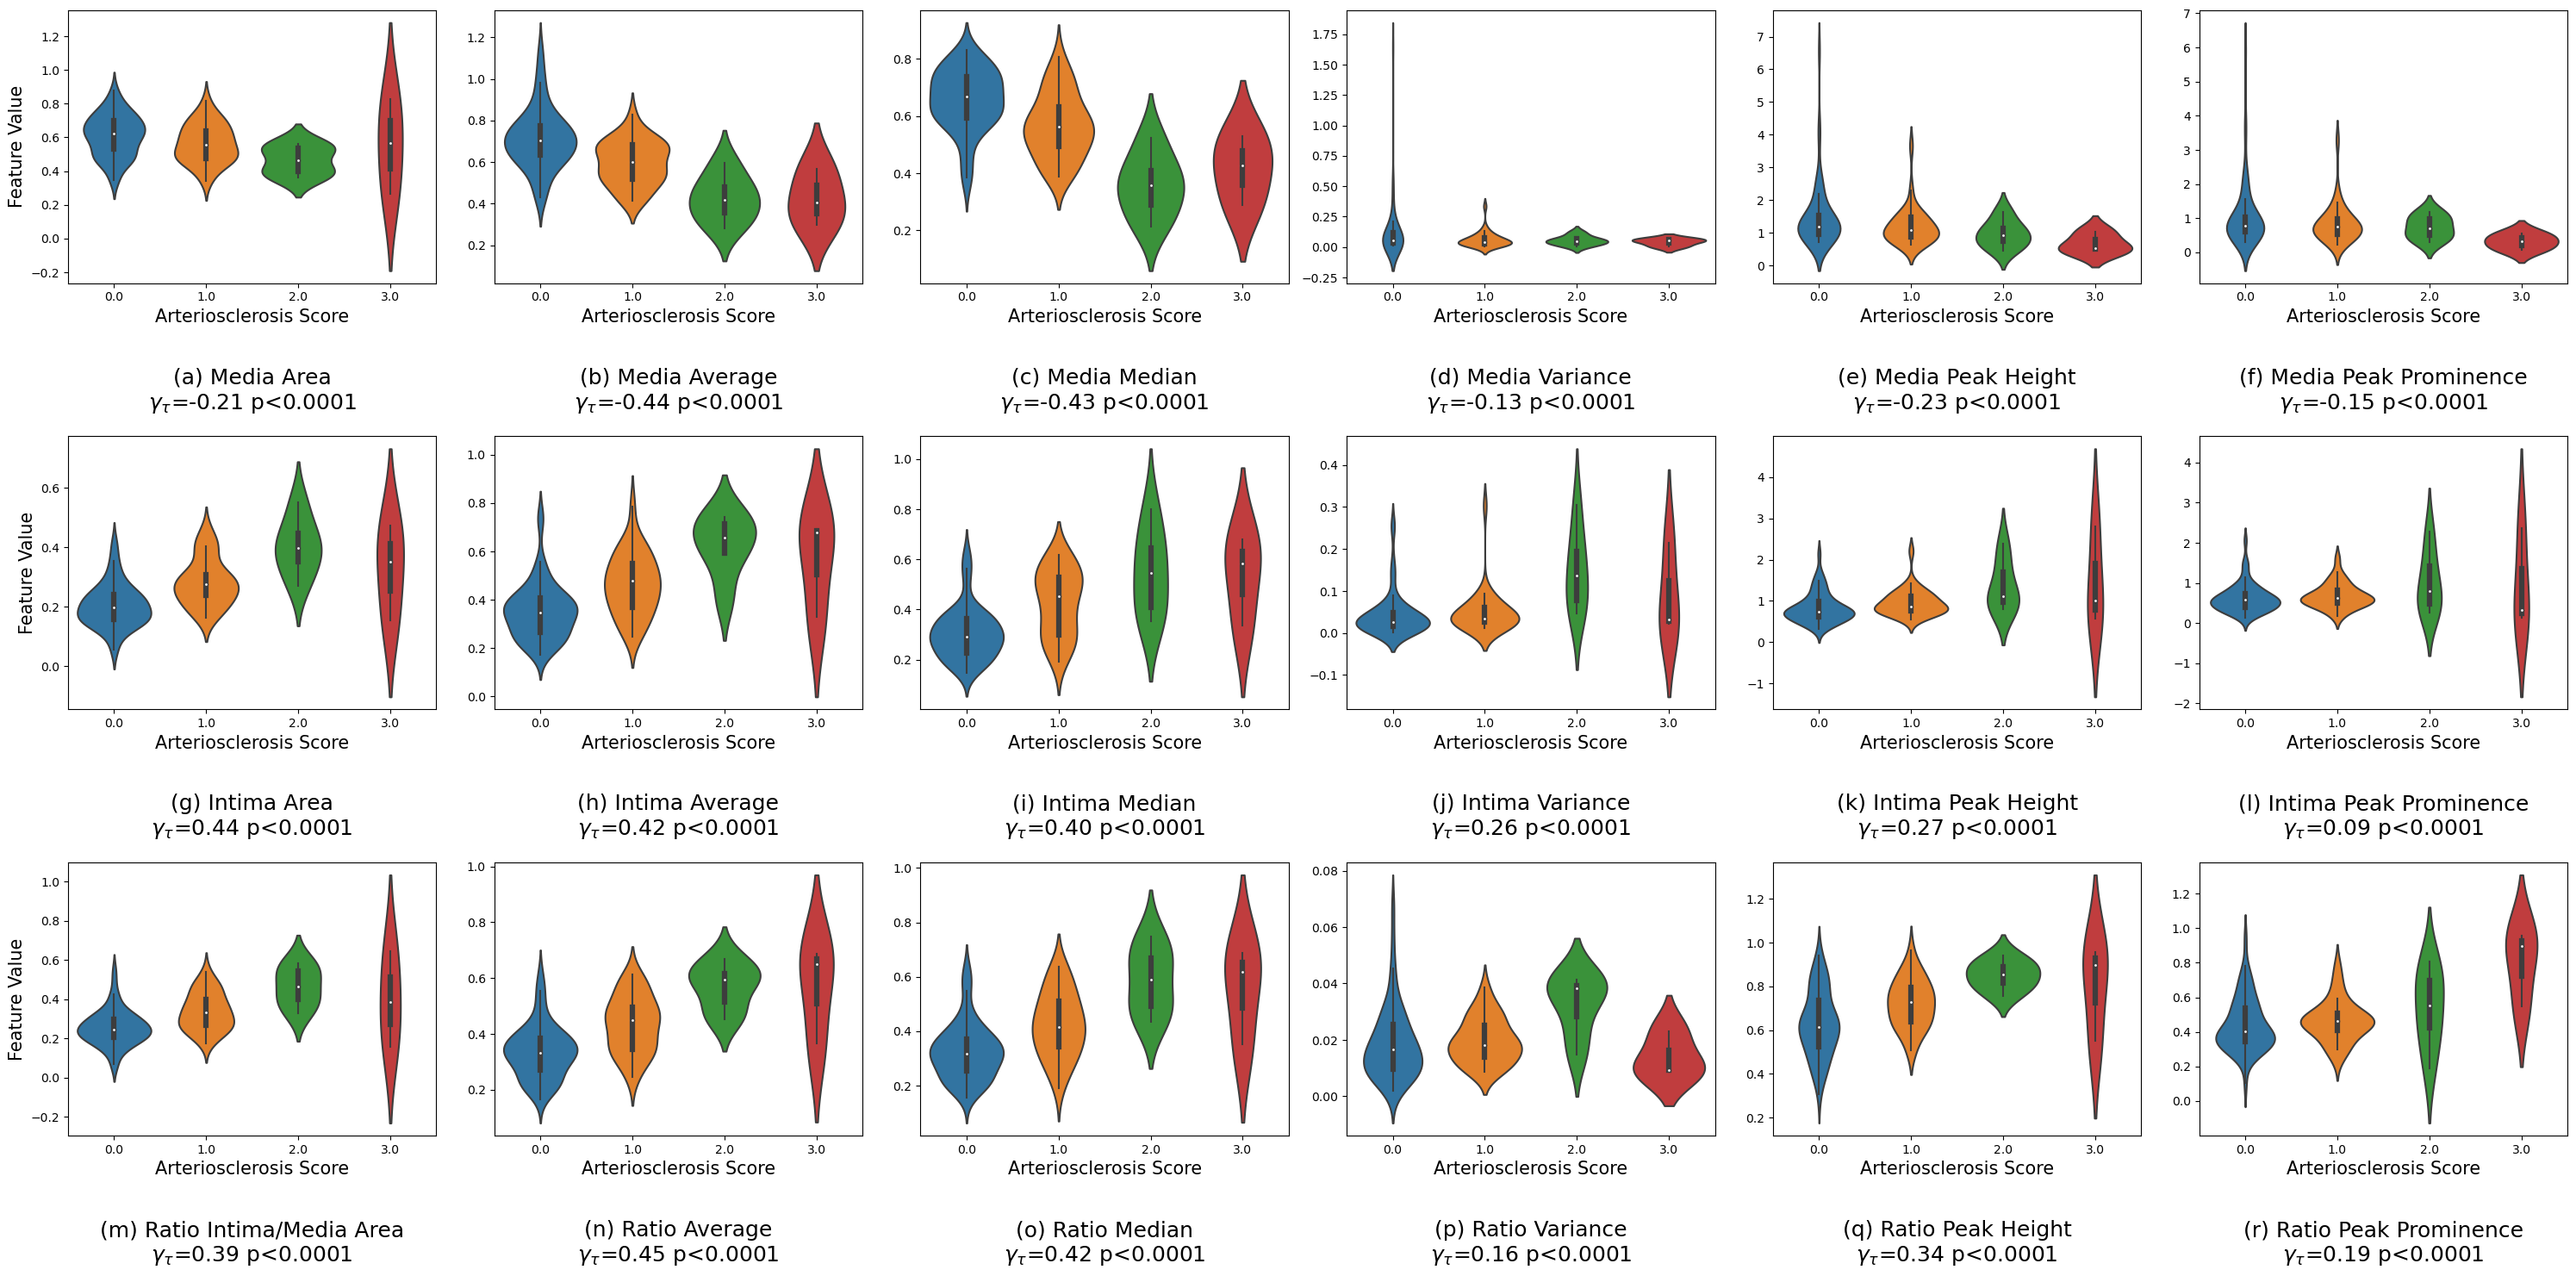

In [16]:
_ = violin_plots(df_features_label, media_features+intima_features+ratio_features)

## Multivariate Feature Evaluation -- Ridge Regression

In [17]:
def ridge_eval(features, y):
#     print("Evaluating Features ", features)
    X = df_features_label.loc[:, features].values
    ridge_model = Ridge(alpha=0.01)
    ridge_model.fit(X, y)
    return ridge_model.score(X, y)

In [18]:
y = df_features_label.loc[:, "Label"].values
features_area = intima_features[:1]+media_features[:1]+ratio_features[:1]
features_thick = intima_features[1:]+media_features[1:]+ratio_features[1:]
features_all = intima_features[:]+media_features[:]+ratio_features[:]

In [19]:
print("Area Only: ", ridge_eval(features_area, y))
print("Thickness Only: ", ridge_eval(features_thick, y))
print("All Features: ", ridge_eval(features_all, y))

Area Only:  0.314269491052551
Thickness Only:  0.48626548585703533
All Features:  0.5040146162885508
